<a href="https://colab.research.google.com/github/thatgeeman/pybx/blob/master/nbs/pybx_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>⚠ Note: walkthrough for v0.4 or greater ⚠
>
>run `! pip freeze | grep pybx` to see the installed version. 

# PyBx

PyBx is a simple python package to generate anchor boxes (aka default/prior boxes) for object detection tasks. 

# SSD for Object Detection

This walkthrough is build around the [Single-Shot Detection (SSD)](https://arxiv.org/pdf/1512.02325.pdf) algorithm. The SSD can be imagined as an encoder-decoder model architecture, where the input image is fed into a `backbone` (encoder) to generate inital features, which then goes through a series of 2D convolution layers (decoders) to perform further feature extraction/prediction tasks at each layer. For a single image, each layer in the decoder produces a total of `N x (4 + C)` predictions. Here `C` is the number of classes (plus one for `background` class) in the detection task and 4 comes from the corners of the rectangular bounding box. 

### Usage of the term Feature/Filter/Channel

Channel: RGB dimensione, also called a Filter

Feature: (W,H) of a single channel

## Example case 
For this example, we assume that our input image is a single channel image is of shape `[B, 3, 300, 300]` where `B` is the batch size. Assuming that a pretrained `VGG-16` is our model `backbone`, the output feature shape would be: `[B, 512, 37, 37]`. Meaning that, 512 channels of shape `[37, 37]` were extracted from each image in the batch. In the subsequent decoder layers, for simplicity we double the channels while halving the feature shape using `3x3` `stride=2` convolutions (except for first decoder layer where convolution is not applied). This results in the following shapes:

```python
torch.Size([-1, 512, 37, 37])  # inp from vgg-16 encoder
torch.Size([-1, 1024, 18, 18]) # first layer logits
torch.Size([-1, 2048, 8, 8])   # second layer logits
torch.Size([-1, 4096, 3, 3])   # third layer logits
```

<img src="https://lilianweng.github.io/lil-log/assets/images/SSD-box-scales.png" width="500" />

## Sample image
Image obtained from USC-SIPI Image Database. 
The USC-SIPI image database is a collection of digitized images. It is maintained primarily to support research in image processing, image analysis, and machine vision. The first edition of the USC-SIPI image database was distributed in 1977 and many new images have been added since then.

Set working directory.

In [1]:
import os
os.environ["DATADIR"] = "../data"

Install package if not already present.

In [2]:
%%bash
EXISTS=$(pip freeze | grep pybx | wc -l)
date
if [ $EXISTS -eq 0 ]
then 
    pip install pybx opencv-python
else
    pip freeze | grep pybx
fi

Sat Aug 19 23:22:46 CEST 2023
-e git+ssh://git@github.com/thatgeeman/pybx.git@0d6ede3d6d65ea6f3580018e987e65685bd401de#egg=pybx


In [3]:
%%bash
echo $DATADIR
mkdir -p $DATADIR
wget -q -O $DATADIR/image.jpg 'https://sipi.usc.edu/database/download.php?vol=misc&img=5.1.12'
ls $DATADIR

../data
NOTES.md
README.md
annots.json
annots_iou.json
annots_key.json
annots_rand.json
box-1.png
box-2.png
box-3.png
box-4.png
box-5.png
image.jpg


## About anchor Boxes

We are expected to provide our models with "good" anchor (aka default/prior) boxes. Strong opinion: Our model is [only as good as the initial anchor boxes](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) that we generate. Inorder to improve the coverage of our model, we tend to add additional anchor boxes of different aspect ratios. Now, for a single image, each layer in the decoder produces a total of `N x A x (4 + C)` predictions. Here `A` is the number of aspect ratios to generate additional anchor boxes.

### Task description

Our aim is to find the maximum number of anchor boxes in varying sizes `feature_szs` and aspect ratios `asp_ratios` across the entire image. We apply no filtering to get rid of low (IOU) anchors.

<img src="https://lilianweng.github.io/lil-log/assets/images/SSD-framework.png" width="600" />

In [4]:
feature_szs = [(37,37), (18,18), (8,8), (3,3)]

In [5]:
asp_ratios = [1/2., 1., 2.]

In [6]:
from operator import __mul__
n_boxes = sum([__mul__(*f) for f in feature_szs]) 
print(f'minimum anchor boxes with 1 aspect ratio: {n_boxes}')
print(f'minimum anchor boxes with {len(asp_ratios)} aspect ratios: {n_boxes*len(asp_ratios)}')

minimum anchor boxes with 1 aspect ratio: 1766
minimum anchor boxes with 3 aspect ratios: 5298


# Loading an image

In [7]:
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import json

In [8]:
datadir = os.environ["DATADIR"]
datadir

'../data'

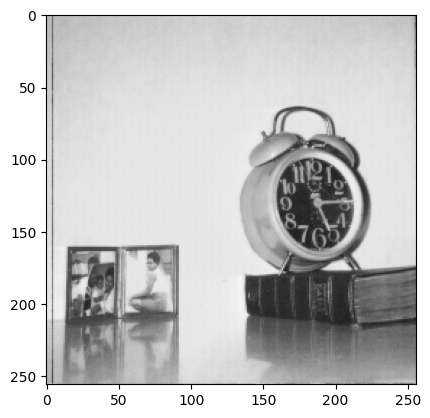

In [9]:
im = cv2.cvtColor(cv2.imread(f"{datadir}/image.jpg"), cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256,256), interpolation=cv2.INTER_NEAREST)
_ = plt.imshow(im)

In [10]:
im.size

196608

We also make 2 truth bounding boxes `bbox` for this image around the clock and the photoframe in `pascal voc` format:

In [11]:
bbox = [
    {
        "x_min": 130,
        "y_min": 63,
        "x_max": 225,
        "y_max": 180,
        "label": "clock"
    },
    {
        "x_min": 13,
        "y_min": 158,
        "x_max": 90,
        "y_max": 213,
        "label": "frame"
    }
]

Save annotations as a json file.

In [12]:
datadir

'../data'

In [13]:
with open(f"{datadir}/annots.json", 'w') as f:
  f.write(json.dumps(bbox))

In [14]:
type(bbox[0])

dict

# Using PyBx

In [15]:
from pybx import anchor

image_sz = (256, 256)     # W, H
feature_sz = (3, 3)       # number of features along W, H
asp_ratio = 1.            # aspect ratio of the anchor box

anchors, labels = anchor.bx(image_sz, feature_sz, asp_ratio)

There are several ways to visualize the anchors. First we import the `vis` method.

In [16]:
from pybx import vis

In [17]:
bbox

[{'x_min': 130, 'y_min': 63, 'x_max': 225, 'y_max': 180, 'label': 'clock'},
 {'x_min': 13, 'y_min': 158, 'x_max': 90, 'y_max': 213, 'label': 'frame'}]

In [18]:
image_sz

(256, 256)

### Visualizing the locally stored `image.png` with provided bounding boxes.

In [19]:
im.size

196608

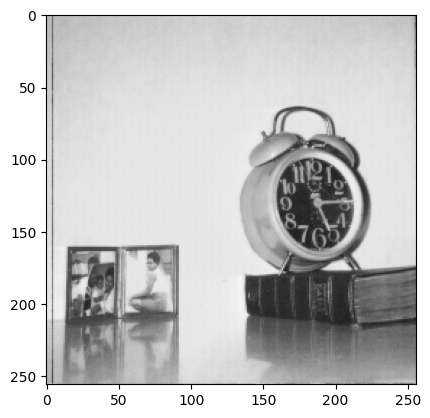

In [20]:
plt.imshow(im)

In [21]:
image_arr = np.array(im)

In [22]:
v = vis.VisBx(image_arr=image_arr, 
              annots=bbox, 
              color={'frame':'red', 'clock':'blue'}) 

<AxesSubplot:>

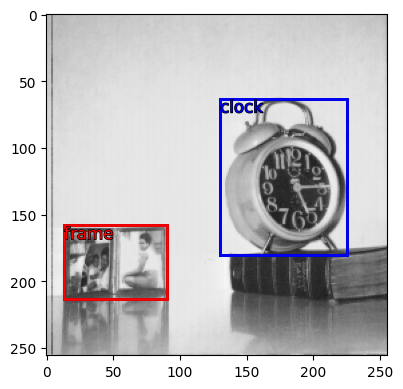

In [23]:
v.show()  # without any arguments

Pass arguments to `show` method to overlay with calculated anchor boxes.

<AxesSubplot:>

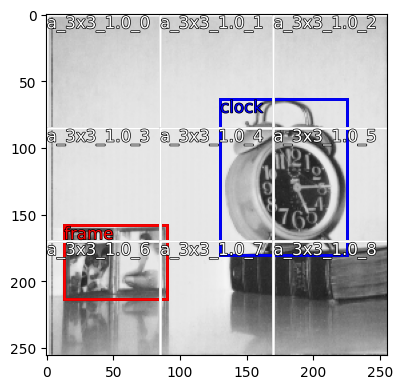

In [24]:
v.show(anchors, labels)

### Using the `sample=True` parameter to load a file 
By default it looks in the current path `pth="."` for an image file `img_fn="image.png"` and annotations file `ann_fn="annots.json"`.

In [25]:
datadir = Path(datadir)

In [26]:
v = vis.VisBx(image_sz=image_sz, 
              color={'frame':'red', 'clock':'blue'}, 
              img_fn=datadir/'image.jpg',
              ann_fn=datadir/'annots.json')

<AxesSubplot:>

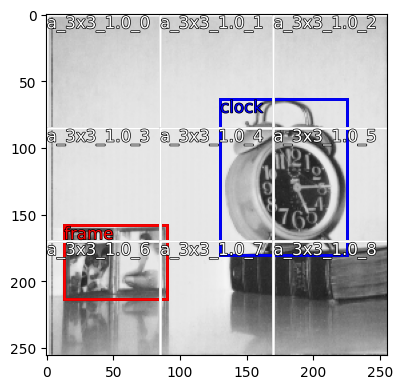

In [27]:
v.show(anchors, labels)

### Using randomly generated noise as `image_arr`

In [28]:
image_sz

(256, 256)

In [29]:
v = vis.VisBx(image_sz=image_sz)

<AxesSubplot:>

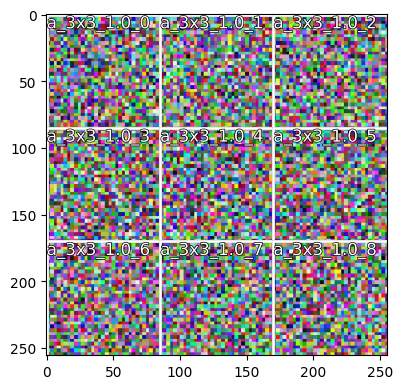

In [30]:
v.show(anchors, labels)

The boxes in white are the anchor boxes. We can hightlight them with a different color by looking up specific box labels.

In [31]:
anchors, labels

([[0, 0, 85, 85],
  [85, 0, 170, 85],
  [170, 0, 256, 85],
  [0, 85, 85, 170],
  [85, 85, 170, 170],
  [170, 85, 256, 170],
  [0, 170, 85, 256],
  [85, 170, 170, 256],
  [170, 170, 256, 256]],
 (#9) ['a_3x3_1.0_0','a_3x3_1.0_1','a_3x3_1.0_2','a_3x3_1.0_3','a_3x3_1.0_4','a_3x3_1.0_5','a_3x3_1.0_6','a_3x3_1.0_7','a_3x3_1.0_8'])

We see there are 9 labels and box coordinates reported by `anchor.bx()` for our `feature_sz=3x3` and single `asp_ratio`. Once instantiated as a `MultiBx`, we can use the `mbx()` method. 

In [32]:
from pybx.basics import *

b = mbx(anchors, labels)  # instantiates MultiBx for us

In [33]:
type(b)

pybx.basics.MultiBx

We can iterate over a `MultiBx` object using list comprehension to understand the internal checks:

In [34]:
[(i, b_.valid) for i, b_ in enumerate(b)]  # only valid boxes shown

[(0, True),
 (1, True),
 (2, True),
 (3, True),
 (4, True),
 (5, True),
 (6, True),
 (7, True),
 (8, True)]

`b_.valid` returned `True` meaning that the box is considered valid. 

We can also calculate the areas of these boxes.

Each box `b_` of the `MultiBx` b is of type `BaseBx` which has some additional methods.

In [35]:
[b_.area for b_ in b]

[7225, 7225, 7310, 7225, 7225, 7310, 7310, 7310, 7396]

Each `BaseBx` is also pseudo-iterable (calling an iterator returns `self` itself and not the coordinates or labels).

In [36]:
b_ = b[0]
[x for x in b_]

[BaseBx(coords=[[0, 0, 85, 85]], label=['a_3x3_1.0_0'])]

We can also stack the `BxTypes`. Issues a `UserWarning` if we try to add `BaseBx`+`MultiBx` or `BaseBx`+`BaseBx`. This is to preserve the philosophy of a `BaseBx`, since adding something to a `BaseBx`, which should technically only hold a single coordinate and label, makes the result a `MultiBx`.

In [37]:
b_s = b_ + b_
b_s.coords, b_s.label

/mnt/data/projects/pybx/pybx/basics.py:481: BxViolation: Change of object type imminent if trying to add <class 'pybx.basics.BaseBx'>+<class 'pybx.basics.BaseBx'>. Use <class 'pybx.basics.BaseBx'>+<class 'pybx.basics.BaseBx'> instead or basics.stack_bxs().
  f"Change of object type imminent if trying to add "


([[0, 0, 85, 85], [0, 0, 85, 85]], (#2) ['a_3x3_1.0_0','a_3x3_1.0_0'])

To safely add two boxes, use `basics.stack_bxs()` method.

In [38]:
stack_bxs(b_, b_).coords

[[0, 0, 85, 85], [0, 0, 85, 85]]

Can also do the same for multiple boxes using `basics.stack_bxs_inplace()` method

In [39]:
stack_bxs_inplace(b_, b[-3], b[-2], b[-1]).coords

[[0, 0, 85, 85], [0, 170, 85, 256], [85, 170, 170, 256], [170, 170, 256, 256]]

From `v1.0.0` `BaseBx` can be iterated. What does it mean to iterate a single coordinate. Technically it should return each point of the coordinate. But `BaseBx` behaves differently on being iterated. It returns the `BaseBx` itself.

In [40]:
[x for x in b_]

[BaseBx(coords=[[0, 0, 85, 85]], label=['a_3x3_1.0_0'])]

In [41]:
b_

BaseBx(coords=[[0, 0, 85, 85]], label=['a_3x3_1.0_0'])

To truly iterate over the coordinates and label, one must do:

In [42]:
[x for x in b_.values]

[[0, 0, 85, 85, 'a_3x3_1.0_0']]

In [43]:
# or 
# [x.label for x in b_]
[x.coords for x in b_]

[[[0, 0, 85, 85]]]

Coming back to the `MultiBx` types, we can display the coordinates of the valid boxes:

In [44]:
[b_.coords for b_ in b]  # selected boxes only!

[[[0, 0, 85, 85]],
 [[85, 0, 170, 85]],
 [[170, 0, 256, 85]],
 [[0, 85, 85, 170]],
 [[85, 85, 170, 170]],
 [[170, 85, 256, 170]],
 [[0, 170, 85, 256]],
 [[85, 170, 170, 256]],
 [[170, 170, 256, 256]]]

Displaying the labels of valid boxes

In [45]:
[b_.label for b_ in b]  # selected boxes only!

[(#1) ['a_3x3_1.0_0'],
 (#1) ['a_3x3_1.0_1'],
 (#1) ['a_3x3_1.0_2'],
 (#1) ['a_3x3_1.0_3'],
 (#1) ['a_3x3_1.0_4'],
 (#1) ['a_3x3_1.0_5'],
 (#1) ['a_3x3_1.0_6'],
 (#1) ['a_3x3_1.0_7'],
 (#1) ['a_3x3_1.0_8']]

We can ofcourse see all the 16 boxes calculated by `anchor.bx()` from the `MultiBx` as well:

In [46]:
b.coords, b.label

([[0, 0, 85, 85],
  [85, 0, 170, 85],
  [170, 0, 256, 85],
  [0, 85, 85, 170],
  [85, 85, 170, 170],
  [170, 85, 256, 170],
  [0, 170, 85, 256],
  [85, 170, 170, 256],
  [170, 170, 256, 256]],
 (#9) ['a_3x3_1.0_0','a_3x3_1.0_1','a_3x3_1.0_2','a_3x3_1.0_3','a_3x3_1.0_4','a_3x3_1.0_5','a_3x3_1.0_6','a_3x3_1.0_7','a_3x3_1.0_8'])

> The `vis.VisBx` internally converts all coordinates in `list`/`json`/`ndarray` to a `MultiBx` and shows only `valid` boxes. 

We can also overlay the features generated by the model on the original image. `logits=True` generates random logits (`np.random.randn`) of the same shape as feature sizes for illustration purposes. 

To aid the explainability of the model, actual model logits can also be passed into the same parameter `logits` as an array or detached tensor.

<AxesSubplot:>

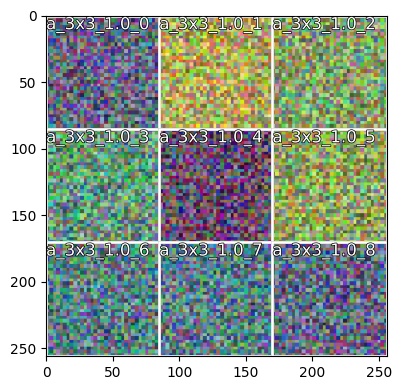

In [47]:
# ask VisBx to use random logits with logits=True
vis.VisBx(image_sz=image_sz, logits=True, feature_sz=feature_sz).show(anchors, labels)

In [48]:
# ask VisBx to use passed logits with logits=logits
logits = np.random.randn(3,3)  # assuming these are model logits
logits

array([[-0.26436432, -0.80592355,  0.03229613],
       [ 0.08434178, -0.86848549, -0.05981583],
       [ 0.76636166,  0.86864882, -0.6038297 ]])

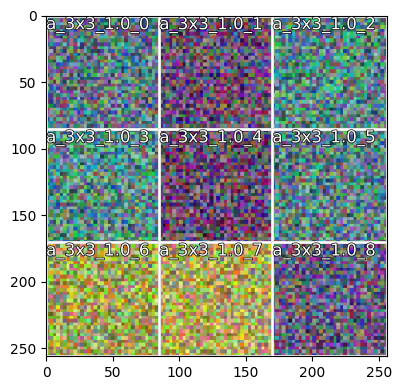

In [49]:
v = vis.VisBx(image_sz=image_sz, logits=logits).show(anchors, labels)

We can hightlight them with a different color if needed. Anchor boxes generated with `named=True` parameter automatically sets the label for each box in the format: `{anchor_sfx}_{feature_sz}_{asp_ratio}_{box_number}`. `anchor_sfx` is also an optional parameter that can be passed to `anchor.bx()`. Here we change the color of one anchor box and one ground truth box.

In [50]:
labels[4]

'a_3x3_1.0_4'

<AxesSubplot:>

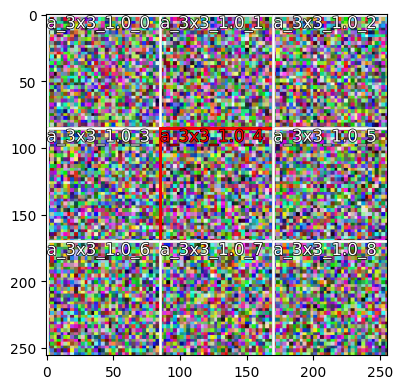

In [51]:
v = vis.VisBx(image_sz=image_sz)
v.show(anchors, labels, color={'a_3x3_1.0_4':'red', 'clock':'orange'})

The box `a_3x3_1.0_4` is not fully highlighted due to overlapping edges of other anchor boxes. A quick and dirty fix to isolate the said box:

<AxesSubplot:>

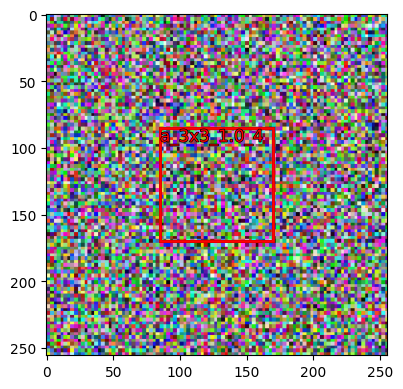

In [52]:
v.show([a for i, a in enumerate(anchors) if labels[i]=='a_3x3_1.0_4'], 
       [l for l in labels if l=='a_3x3_1.0_4'],
       color={'a_3x3_1.0_4':'red', 'clock':'orange'})

# Working with mulitple feature sizes and aspect ratios
Finally we calculate anchor boxes for multiple feature sizes and aspect ratios.

In [53]:
feature_szs = [(10, 10), (3, 3), (2, 2)]
asp_ratios = [0.3, 1/2., 2.]

anchors, labels = anchor.bxs(image_sz, feature_szs, asp_ratios)

This is essentially a wrapper to do list comprehension over the passed feature sizes and aspect ratios (but additionally stacks them together into an ndarray).

```
[anchor.bx(image_sz, f, ar) for f in feature_szs for ar in asp_ratios]
```

In [54]:
labels[4], labels[5]

('a_10x10_0.3_4', 'a_10x10_0.3_5')

<AxesSubplot:>

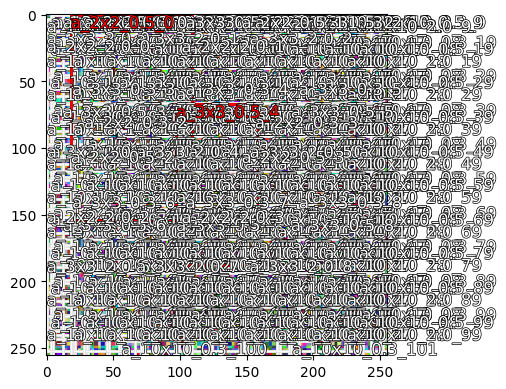

In [55]:
v = vis.VisBx(image_sz=image_sz)
v.show(anchors, labels, color={'a_3x3_0.5_4':'red', 'a_2x2_0.5_0':'red'})

Thats a lot of boxes.

# Use ground truth boxes for model training

In [56]:
from pybx.anchor import get_gt_thresh_iou, get_gt_max_iou

In [57]:
bbox

[{'x_min': 130, 'y_min': 63, 'x_max': 225, 'y_max': 180, 'label': 'clock'},
 {'x_min': 13, 'y_min': 158, 'x_max': 90, 'y_max': 213, 'label': 'frame'}]

The following function returns ground truth anchors with an IOU > `iou_thresh` for each class in the label bounding boxes passed.

In [58]:
gt_anchors, gt_ious, gt_masks = get_gt_thresh_iou(
    true_annots=bbox,
    anchor_boxes=anchors,
    anchor_labels=labels,
    return_ious=True,
    return_masks=False,
    update_labels=False,
)

In [59]:
gt_anchors

{'clock': MultiBx(coords=[[183, 67, 243, 188], [152, 97, 256, 158], [156, 0, 227, 180], [156, 75, 227, 256], [146, 0, 237, 154], [146, 101, 237, 256]], label=['a_3x3_0.5_5', 'a_3x3_2.0_5', 'a_2x2_0.3_1', 'a_2x2_0.3_3', 'a_2x2_0.5_1', 'a_2x2_0.5_3']),
 'frame': MultiBx(coords=[[19, 135, 66, 256], [12, 152, 72, 256], [0, 146, 154, 237]], label=['a_3x3_0.3_6', 'a_3x3_0.5_6', 'a_2x2_2.0_2'])}

Ground truth labels are returned per true label.

In [60]:
all_gt_anchors = gt_anchors['clock'] + gt_anchors['frame']
all_gt_anchors

MultiBx(coords=[[183, 67, 243, 188], [152, 97, 256, 158], [156, 0, 227, 180], [156, 75, 227, 256], [146, 0, 237, 154], [146, 101, 237, 256], [19, 135, 66, 256], [12, 152, 72, 256], [0, 146, 154, 237]], label=['a_3x3_0.5_5', 'a_3x3_2.0_5', 'a_2x2_0.3_1', 'a_2x2_0.3_3', 'a_2x2_0.5_1', 'a_2x2_0.5_3', 'a_3x3_0.3_6', 'a_3x3_0.5_6', 'a_2x2_2.0_2'])

<AxesSubplot:>

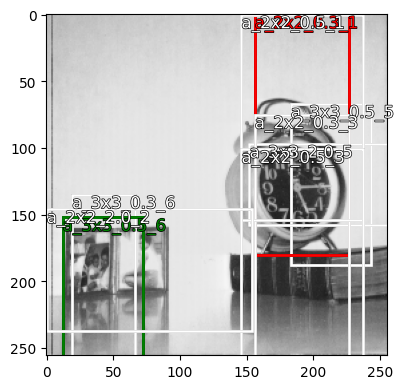

In [61]:
v = vis.VisBx(image_arr=image_arr)
v.show(all_gt_anchors, color={'a_2x2_0.3_1':'red', 'a_3x3_0.5_6': 'green'}) 

The following function returns two positive ground truth anchors with largest IOU for each class in the label bounding boxes passed.

In [67]:
gt_anchors, gt_ious, gt_masks = get_gt_max_iou(
    true_annots=bbox,
    anchor_boxes=anchors,
    anchor_labels=labels,
    return_ious=True,
    return_masks=True,
    update_labels=False,
    positive_boxes=1, # can add extra boxes 
)

In [68]:
gt_anchors

{'clock': BaseBx(coords=[[156, 0, 227, 180]], label=['a_2x2_0.3_1']),
 'frame': BaseBx(coords=[[12, 152, 72, 256]], label=['a_3x3_0.5_6'])}

In [69]:
all_gt_anchors = gt_anchors['clock'] + gt_anchors['frame']
all_gt_anchors

/mnt/data/projects/pybx/pybx/basics.py:481: BxViolation: Change of object type imminent if trying to add <class 'pybx.basics.BaseBx'>+<class 'pybx.basics.BaseBx'>. Use <class 'pybx.basics.BaseBx'>+<class 'pybx.basics.BaseBx'> instead or basics.stack_bxs().
  f"Change of object type imminent if trying to add "


MultiBx(coords=[[156, 0, 227, 180], [12, 152, 72, 256]], label=['a_2x2_0.3_1', 'a_3x3_0.5_6'])

<AxesSubplot:>

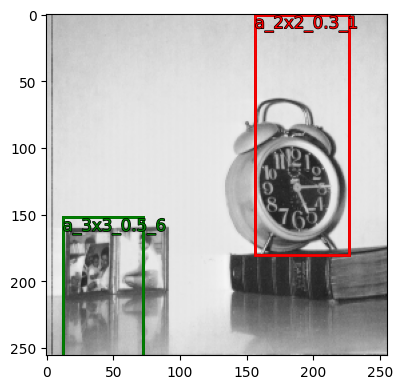

In [70]:
v = vis.VisBx(image_arr=image_arr)
v.show(all_gt_anchors, color={'a_2x2_0.3_1':'red', 'a_3x3_0.5_6': 'green'}) 

# Calculating ground truth offsets wrt all anchor boxes

In [71]:
gt_anchors, gt_ious, gt_masks

({'clock': BaseBx(coords=[[156, 0, 227, 180]], label=['a_2x2_0.3_1']),
  'frame': BaseBx(coords=[[12, 152, 72, 256]], label=['a_3x3_0.5_6'])},
 {'clock': (#1) [0.5102], 'frame': (#1) [0.4488]},
 {'clock': (#341) [False,False,False,False,False,False,False,False,False,False...],
  'frame': (#341) [False,False,False,False,False,False,False,False,False,False...]})

In [73]:
from pybx.anchor import get_gt_offsets

In [76]:
bbox 

[{'x_min': 130, 'y_min': 63, 'x_max': 225, 'y_max': 180, 'label': 'clock'},
 {'x_min': 13, 'y_min': 158, 'x_max': 90, 'y_max': 213, 'label': 'frame'}]

In [84]:
gt_offsets_clock, gt_labels_clock = get_gt_offsets(
    bbox[0],  # pass a single bounding box for an object
    anchors,  # calculated anchor boxes
    masks=gt_masks["clock"],  # correponding masks to indicate postive/negative anchors
    update_labels=True  # to replace positive anchors with ground truth class label and negative anchors with 'background' label
)

Offsets for negative anchors are not calculated.

In [85]:
gt_offsets_clock

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

To show just the offsets that matter.

In [86]:
gt_offsets_clock[gt_masks["clock"]]

array([[-1.9718,  1.75  ,  1.456 , -2.1539]])

In [88]:
gt_labels_clock # labels were updated

(#341) ['background','background','background','background','background','background','background','background','background','background'...]

In [91]:
gt_labels_clock[gt_masks["clock"]]  # the positive anchor label is set to the ground truth label

(#1) ['clock']

To calculate all offsets, just call the function without any mask.

In [100]:
gt_offsets_clock, _ = get_gt_offsets(
    bbox[0],  # pass a single bounding box for an object
    anchors,  # calculated anchor boxes
    masks=None,  # correponding masks to indicate postive/negative anchors 
)

In [101]:
gt_offsets_clock

array([[ 1.182143e+02,  2.875000e+01,  9.574100e+00,  5.893300e+00],
       [ 9.964290e+01,  2.875000e+01,  9.574100e+00,  5.893300e+00],
       [ 7.600000e+01,  2.875000e+01,  9.229100e+00,  5.893300e+00],
       ...,
       [-6.450000e-02,  6.373600e+00, -2.447700e+00,  1.256600e+00],
       [ 6.526000e+00, -7.692300e+00, -2.415400e+00,  1.256600e+00],
       [-6.450000e-02, -7.692300e+00, -2.447700e+00,  1.256600e+00]])

As simple as that! Do leave a star or raise issues and suggestions on the project page if you found this useful! 

Project page: [GitHub](https://github.com/thatgeeman/pybx) 

PyPi Package: [PyBx](https://pypi.org/project/pybx/)